# Extra libraries to install

In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 5.0 MB/s 
  Created wheel for pyod: filename=pyod-1.0.6-py3-none-any.whl size=175098 sha256=ec383785f3e02933eca6b38fa94976a2dbd34d13b366e0697a2dfdf4626ae1ce
  Stored in directory: /root/.cache/pip/wheels/98/93/e6/6d40410d9635ecde42d06041a1ba7f2ee7396e036fcf702e73
Successfully built pyod


# Drive connection and file paths definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC2'

# Import libraries

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


from pyod.models.lof import LOF

# Data Generation

IF you want to generate new data run the next four cells, otherwise skip them and load the saved file

In [ ]:
parameters1 = {
        'time_delta':5
    }

In [ ]:
device_filter = {
    'vendor':'Versa'
}

In [ ]:
metric_df = sands.generate_device_metric_time_range(datetime.now(),datetime.now()+timedelta(minutes=4),parameters1,"none",['mem_utilization'],device_filter)


In [ ]:
metric_df.to_csv(join(path_files,'mem_utilization_sdwan_metric.csv'))

Load the saved dataset:

In [ ]:
metric_df=pd.read_csv(join(path_files,'mem_utilization_sdwan_metric.csv'),index_col=0)

In [ ]:
metric_df

,timestamp,mem_utilization,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,1668164858,30,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1
1,1668164858,33,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2
2,1668164858,33,E-2-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_branch,10.3.2.1
3,1668164858,30,E-2-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_branch,10.3.2.2
4,1668164858,31,E-3-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_branch,10.3.3.1
...,...,...,...,...,...,...,...,...,...,...
195,1668164858,30,E-98-2,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.98.2
196,1668164858,32,E-99-1,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.99.1
197,1668164858,32,E-99-2,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.99.2
198,1668164858,78,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1


timestamp is not relevant in this use case, we will focus on the memory utilization column, and the device_name columns. All other columns will be ignored for the moment.

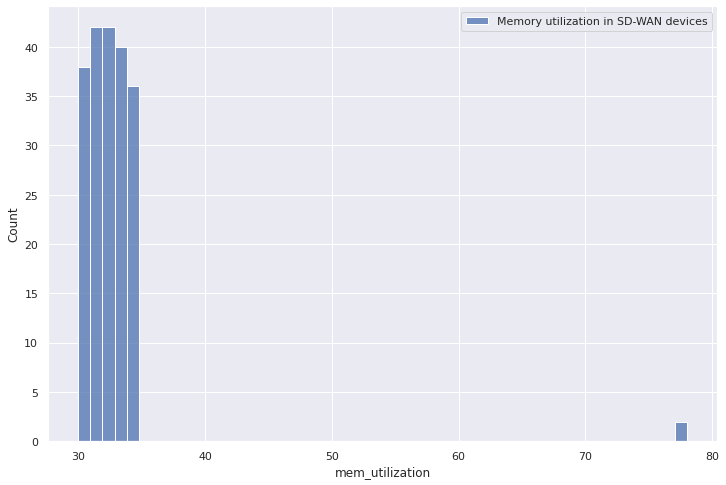

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=metric_df,x='mem_utilization', bins=50)
plt.legend(['Memory utilization in SD-WAN devices'])

# Z-score based outlier detection

In [ ]:

THRESHOLD = 3
def identify_outliers(input_data,target_column,threshold = THRESHOLD):
  outliers=[]
  median=np.median(input_data[target_column])
  std=np.std(input_data[target_column])
  for i,entry in input_data.iterrows():
    zscore=np.abs((entry[target_column]-median)/std)
    if zscore > threshold:
      outliers.append(i)
  return outliers


In [ ]:
outlier_list = identify_outliers(metric_df,'mem_utilization',THRESHOLD)
print('Outlier list:')
print(metric_df.loc[outlier_list,['device_name','mem_utilization']])

Outlier list:
    device_name  mem_utilization
198     E-100-1               78
199     E-100-2               78


# Local Outlier Factor algorithm

In [ ]:
X_train = metric_df['mem_utilization'].values.reshape(-1,1)
X_test = X_train

In [ ]:
lof = LOF(contamination=0.05)


In [ ]:
lof = LOF(contamination=0.05) 
lof.fit(X_train)

# Training data
y_train_scores = lof.decision_function(X_train)
y_train_pred = lof.predict(X_train)

# Test data
y_test_scores = lof.decision_function(X_test)
y_test_pred = lof.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Goal of this function is count how many 0 or 1s are in the vector. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The threshold for the defined contanimation rate:" , lof.threshold_)

The training data: {0: 198, 1: 2}
The threshold for the defined contanimation rate: 1.0


In [ ]:
y_test_scores

array([1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e

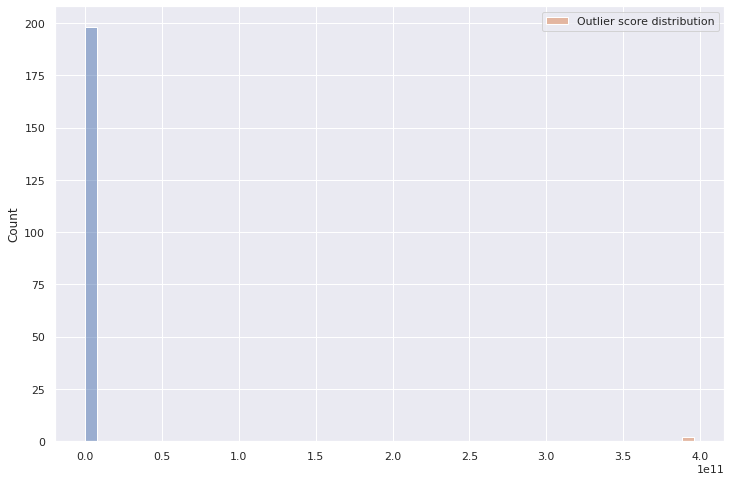

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(x=y_test_scores, bins=50,hue=y_test_pred)
plt.legend(['Outlier score distribution'])

In [ ]:
print('Outlier list:')
print(metric_df.loc[y_test_pred==1,['device_name','mem_utilization']])

Outlier list:
    device_name  mem_utilization
198     E-100-1               78
199     E-100-2               78
